In [ ]:
import os
import gdown; 

In [ ]:
'''os.makedirs('experiments')
os.makedirs('inputs')'''

In [5]:
import wandb
model_path = 'experiments'
api = wandb.Api()
artifact = api.artifact('ravenser/gcfsr_base_512/net_g_170001.pth:v0')
artifact.download(root = model_path)
wandb.finish()

wandb: Downloading large artifact net_g_170001.pth:v0, 294.24MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:1:43.9


Testing WIN_20240430_16_48_10_Pro


<Figure size 640x480 with 0 Axes>

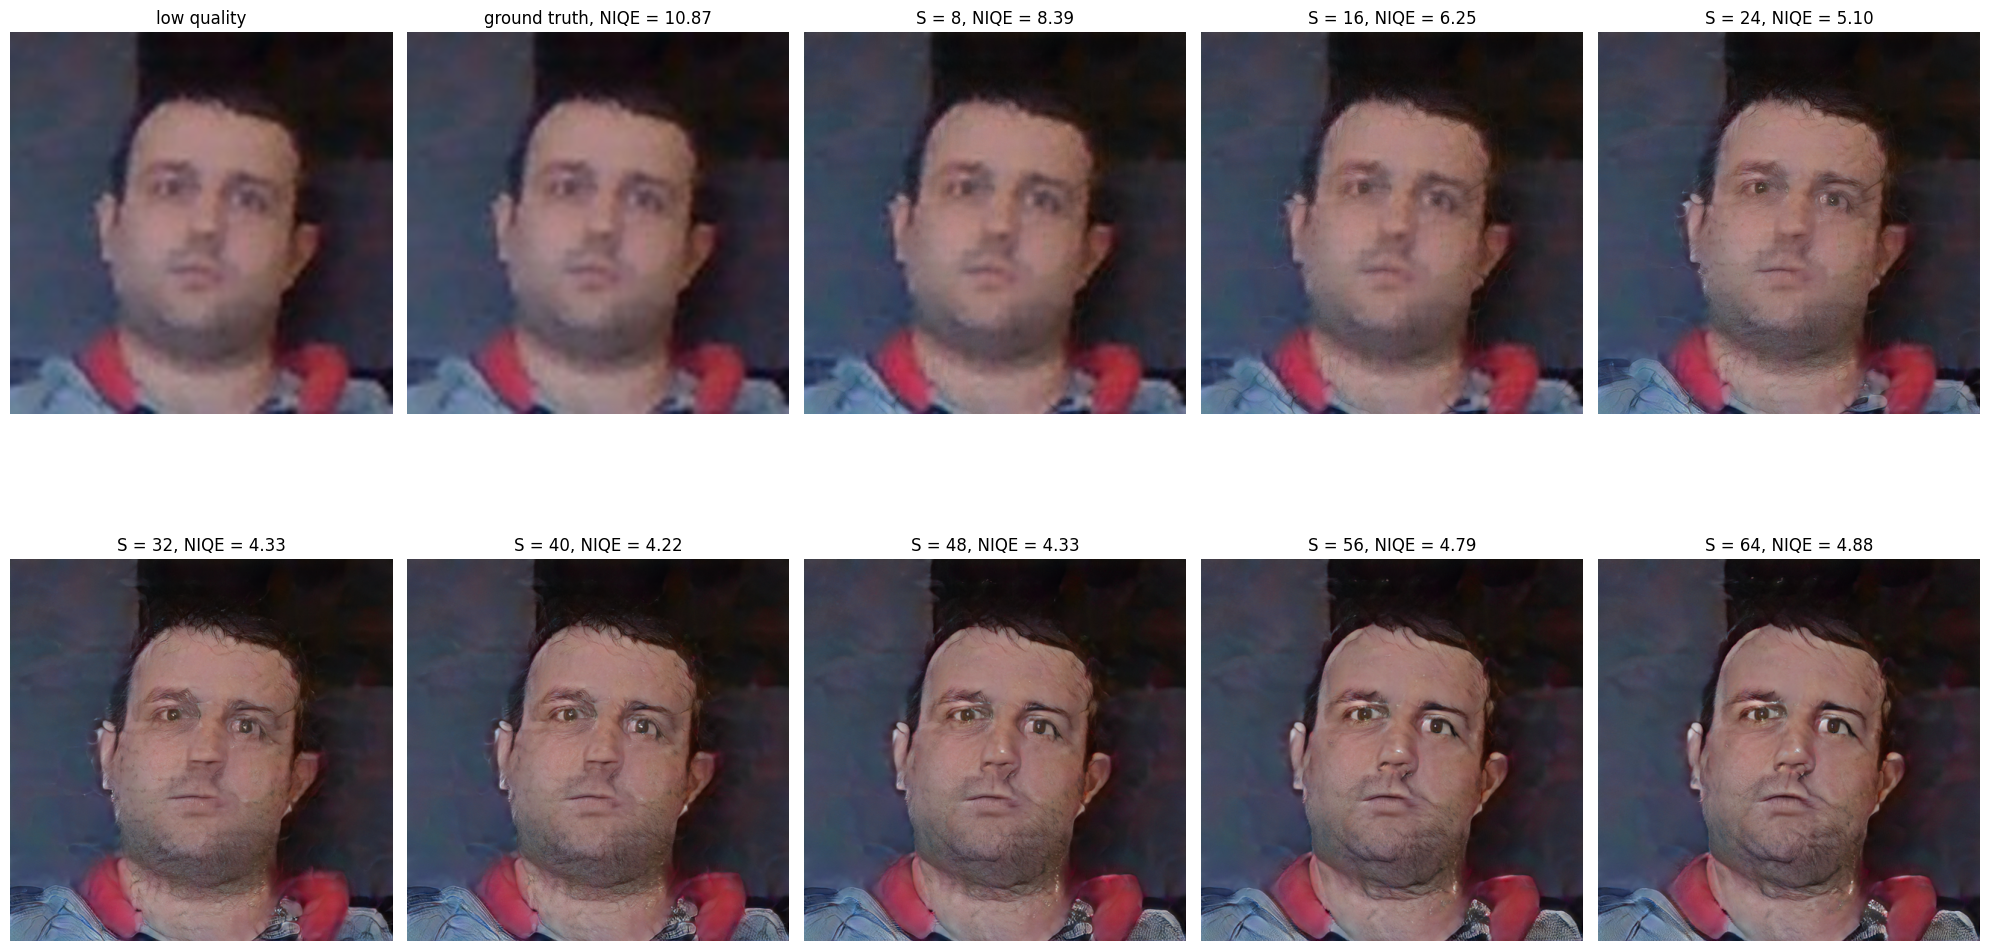

In [38]:
import gc
import argparse
import cv2
import math
import glob
import numpy as np
import os
import torch
from torchvision.transforms.functional import normalize
from torchvision import utils

from basicsr.data import degradations as degradations
from basicsr.archs.gcfsr_arch import GCFSR_blind, GCFSR
from basicsr.utils.matlab_functions import imresize
import matplotlib.pyplot as plt
from basicsr.metrics import psnr_ssim, niqe

def generate(img, cond, g_ema, imgname, outputname, s):

    with torch.no_grad():
        output, _ = g_ema(img, cond)

        output = output.data.squeeze().float().cpu().clamp_(-1, 1).numpy()
        output = (output + 1) / 2
        output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
        output = (output * 255.0).round().astype(np.uint8)
        os.makedirs(f'{outputname}/{imgname}', exist_ok=True)
        cv2.imwrite(os.path.join(f'{outputname}/{imgname}', f'{imgname}_s_{s}.png'), output)
        return output

def toformat(imggt):
    with torch.no_grad():
        imggt = torch.from_numpy(np.transpose(imggt[:, :, [2, 1, 0]], (2, 0, 1))).float()
        imggt = torch.clamp((imggt * 255.0).round(), 0, 255) / 255.
        normalize(imggt, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], inplace=True)
        imggt = imggt.unsqueeze(0)
        imggt = imggt.data.squeeze().float().cpu().clamp_(-1, 1).numpy()
        imggt = (imggt + 1) / 2
        imggt = np.transpose(imggt[[2, 1, 0], :, :], (1, 2, 0))
        imggt = (imggt * 255.0).round().astype(np.uint8)
        return imggt

def main(inputt, model_path, output, scale, only_up = False):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    os.makedirs(output, exist_ok=True)
    gc.collect()
    # set up model
    model = GCFSR(512, channel_multiplier=1, num_style_feat=256)
    #model = GCFSR_blind(512)
    #model = GCFSR(1024)
    model.load_state_dict(torch.load(model_path)['params_ema'], strict=False)
    #model.load_state_dict(torch.load(model_path), strict=False)
    model.eval()
    model = model.to(device)
    imgname = os.path.splitext(os.path.basename(inputt))[0]
    print('Testing', imgname)
    # read image
    img = cv2.imread(inputt, cv2.IMREAD_COLOR).astype(np.float32) / 255.
    if only_up:
        img = imresize(img, scale)
        imggt = img
        a = 8
        b = 65
    else:
        imggt = img
        img = imresize(img, 1/scale)
        img = imresize(img, scale)
        a = 24
        b = 81
    #imggt = img
    imglq = img 
    ###### numpy to tensor, BGR to RGB
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    ###### clamp
    img = torch.clamp((img * 255.0).round(), 0, 255) / 255.
        ###### normalization
    normalize(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], inplace=True)
    img = img.unsqueeze(0).to(device)

        ###### setting conditions
    imgsrlist = [imglq, imggt]
    imggt= toformat(imggt)
    condlist = ['low quality', f'ground truth, NIQE = {niqe.calculate_niqe(imggt,0):.2f}']
    if only_up:
        for i in range(a, b, 8):
            in_size = i / 64.
            cond = torch.from_numpy(np.array([in_size], dtype=np.float32)).unsqueeze(0).to(device)
            img_sr = generate(img, cond, model, imgname, output,i)    
            imgsrlist.append(img_sr)

            condlist.append(f'S = {i}, NIQE = {niqe.calculate_niqe(img_sr,0):.2f}')
            gc.collect()
            del img_sr
    else:
        for i in range(a, b, 8):
            in_size = i / 64.
            cond = torch.from_numpy(np.array([in_size], dtype=np.float32)).unsqueeze(0).to(device)
            img_sr = generate(img, cond, model, imgname, output,i)    
            imgsrlist.append(img_sr)

            condlist.append(f'S = {i}, PSNR = {psnr_ssim.calculate_psnr(img_sr, imggt, 0):.2f}, NIQE = {niqe.calculate_niqe(img_sr,0):.2f}')
            gc.collect()
            del img_sr
            
        

    plt.figure()
    f, axarr = plt.subplots(2,5, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

    axarr = axarr.flatten()
    for i, image in enumerate(imgsrlist):
        axarr[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
        axarr[i].axis('off')
        axarr[i].set_title(condlist[i])
    #plt.subplots_adjust(hspace=0.00009)
    plt.tight_layout()
    gc.collect()
    del imgsrlist
    del imglq
    del imggt
    del img
    del model
    plt.show()
#inputt, scale, only_up ='celebaHQ_512_1000\985.jpg', 16, False
#inputt, scale, only_up='celebaHQ_512_1000/297.jpg', 16, False 
#inputt, scale, only_up = 'inputs\WIN_20240430_16_48_10_Pro.jpg', 4, True #IN DIPLOMA
#inputt, scale, only_up = 'inputs\WIN_20240511_21_14_09_Pro.jpg', 4, True
inputt, scale, only_up = 'inputs\photo_2024-05-11_21-24-41.jpg', 2, True #IN DIPLOMA
#inputt, scale, only_up = 'inputs\photo_2024-05-11_21-24-44.jpg', 2, True
#inputt, scale, only_up = 'inputs\photo_2024-05-11_21-24-32.jpg', 2, True

model_path='experiments/net_g_140001.pth'
#model_path='experiments/net_g_170001.pth'
#model_path='experiments/net_g_87501.pth'
main(inputt = inputt, model_path =model_path , output = 'results', scale = scale, only_up = only_up)

In [ ]:
import datetime
import wandb
import logging
import math
import time
import torch
from os import path as osp

from basicsr.data import build_dataloader, build_dataset
from basicsr.data.data_sampler import EnlargedSampler
from basicsr.data.prefetch_dataloader import CPUPrefetcher, CUDAPrefetcher
from basicsr.models import build_model
from basicsr.utils import (MessageLogger, check_resume, get_env_info, get_root_logger, get_time_str, init_tb_logger,
                           init_wandb_logger, make_exp_dirs, mkdir_and_rename, scandir)
from basicsr.utils.options import dict2str, parse_options, parse
from basicsr.utils.dist_util import get_dist_info, init_dist

In [ ]:
def init_tb_loggers(opt):
    # initialize wandb logger before tensorboard logger to allow proper sync
    if (opt['logger'].get('wandb') is not None) and (opt['logger']['wandb'].get('project')
                                                     is not None) and ('debug' not in opt['name']):
        assert opt['logger'].get('use_tb_logger') is True, ('should turn on tensorboard when using wandb')
        run = init_wandb_logger(opt)
    tb_logger = None
    if opt['logger'].get('use_tb_logger') and 'debug' not in opt['name']:
        tb_logger = init_tb_logger(log_dir=osp.join(opt['root_path'], 'tb_logger', opt['name']))
    return tb_logger, run


def create_train_val_dataloader(opt, logger):
    # create train and val dataloaders
    train_loader, val_loader = None, None
    for phase, dataset_opt in opt['datasets'].items():
        if phase == 'train':
            dataset_enlarge_ratio = dataset_opt.get('dataset_enlarge_ratio', 1)
            train_set = build_dataset(dataset_opt)
            train_sampler = EnlargedSampler(train_set, opt['world_size'], opt['rank'], dataset_enlarge_ratio)
            train_loader = build_dataloader(
                train_set,
                dataset_opt,
                num_gpu=opt['num_gpu'],
                dist=opt['dist'],
                sampler=train_sampler,
                seed=opt['manual_seed'])

            num_iter_per_epoch = math.ceil(
                len(train_set) * dataset_enlarge_ratio / (dataset_opt['batch_size_per_gpu'] * opt['world_size']))
            total_iters = int(opt['train']['total_iter'])
            total_epochs = math.ceil(total_iters / (num_iter_per_epoch))
            logger.info('Training statistics:'
                        f'\n\tNumber of train images: {len(train_set)}'
                        f'\n\tDataset enlarge ratio: {dataset_enlarge_ratio}'
                        f'\n\tBatch size per gpu: {dataset_opt["batch_size_per_gpu"]}'
                        f'\n\tWorld size (gpu number): {opt["world_size"]}'
                        f'\n\tRequire iter number per epoch: {num_iter_per_epoch}'
                        f'\n\tTotal epochs: {total_epochs}; iters: {total_iters}.')

        elif phase == 'val':
            val_set = build_dataset(dataset_opt)
            val_loader = build_dataloader(
                val_set, dataset_opt, num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])
            logger.info(f'Number of val images/folders in {dataset_opt["name"]}: ' f'{len(val_set)}')
        else:
            raise ValueError(f'Dataset phase {phase} is not recognized.')

    return train_loader, train_sampler, val_loader, total_epochs, total_iters


def load_resume_state(opt):
    resume_state_path = None
    if opt['auto_resume']:
        make_exp_dirs(opt)
        if (opt['logger'].get('wandb') is not None) and (opt['logger']['wandb'].get('project')
                                                     is not None) and ('debug' not in opt['name']):
            model_path = osp.join('experiments', opt['name'], 'models')
            state_path = osp.join('experiments', opt['name'], 'training_states')
            api = wandb.Api()
            artifact = api.artifact(opt['logger']['wandb']['modelgpath'])
            artifact.download(root = model_path)
            artifact = api.artifact(opt['logger']['wandb']['modeldpath'])
            artifact.download(root = model_path)
            artifact = api.artifact(opt['logger']['wandb']['statepath'])
            artifact.download(root = state_path)
            wandb.finish()
        if osp.isdir(state_path):
            states = list(scandir(state_path, suffix='state', recursive=False, full_path=False))
            if len(states) != 0:
                states = [float(v.split('.state')[0]) for v in states]
                resume_state_path = osp.join(state_path, f'{max(states):.0f}.state')
                opt['path']['resume_state'] = resume_state_path
    else:
        if opt['path'].get('resume_state'):
            resume_state_path = opt['path']['resume_state']

    if resume_state_path is None:
        resume_state = None
    else:
        device_id = torch.cuda.current_device()
        resume_state = torch.load(resume_state_path, map_location=lambda storage, loc: storage.cuda(device_id))
        check_resume(opt, resume_state['iter'])
    return resume_state

In [ ]:
import gc
def val_pipeline(root_path, opt_path, is_train = True, debug=False, auto_resume = True):
    # parse options, set distributed setting, set ramdom seed
    opt = parse(opt_path, root_path, is_train=is_train, debug=debug)
    opt['root_path'] = root_path
    opt['auto_resume'] = auto_resume
    opt['dist'] = False
    opt['rank'], opt['world_size'] = get_dist_info()
    #opt['path']['pretrain_network_g'] = '/kaggle/working/GCFSR/experiments/gcfsr_scale4to16_ffhq512/models/net_g_19001.pth'
    #opt['path']['pretrain_network_d'] = '/kaggle/working/GCFSR/experiments/gcfsr_scale4to16_ffhq512/models/net_d_19001.pth'
    #opt['path']['resume_state'] = '/kaggle/working/GCFSR/experiments/gcfsr_scale4to16_ffhq512/training_states/19001.state'
    
    
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

    # load resume states if necessary
    resume_state = load_resume_state(opt)
    # mkdir for experiments and logger
    if resume_state is None:
        make_exp_dirs(opt)
        if opt['logger'].get('use_tb_logger') and 'debug' not in opt['name'] and opt['rank'] == 0:
            mkdir_and_rename(osp.join(opt['root_path'], 'tb_logger', opt['name']))

    # WARNING: should not use get_root_logger in the above codes, including the called functions
    # Otherwise the logger will not be properly initialized
    log_file = osp.join(opt['path']['log'], f"train_{opt['name']}_{get_time_str()}.log")
    logger = get_root_logger(logger_name='basicsr', log_level=logging.INFO, log_file=log_file)
    logger.info(get_env_info())
    logger.info(dict2str(opt))
    # initialize wandb and tb loggers
    tb_logger, run = init_tb_loggers(opt)
    # create train and validation dataloaders
    result = create_train_val_dataloader(opt, logger)
    train_loader, train_sampler, val_loader, total_epochs, total_iters = result

    # create model
    if resume_state:  # resume training
        model = build_model(opt)
        model.resume_training(resume_state)  # handle optimizers and schedulers
        logger.info(f"Resuming training from epoch: {resume_state['epoch']}, " f"iter: {resume_state['iter']}.")
        start_epoch = resume_state['epoch']
        current_iter = resume_state['iter']


    # create message logger (formatted outputs)
    msg_logger = MessageLogger(opt, current_iter, tb_logger)

    # dataloader prefetcher
    prefetch_mode = opt['datasets']['train'].get('prefetch_mode')
    if prefetch_mode is None or prefetch_mode == 'cpu':
        prefetcher = CPUPrefetcher(train_loader)
    elif prefetch_mode == 'cuda':
        prefetcher = CUDAPrefetcher(train_loader, opt)
        logger.info(f'Use {prefetch_mode} prefetch dataloader')
        if opt['datasets']['train'].get('pin_memory') is not True:
            raise ValueError('Please set pin_memory=True for CUDAPrefetcher.')
    else:
        raise ValueError(f'Wrong prefetch_mode {prefetch_mode}.' "Supported ones are: None, 'cuda', 'cpu'.")

    # validation
    model.validation(val_loader, current_iter, tb_logger, opt['val']['save_img'])
    if tb_logger:
        tb_logger.close()
        
root_path = '/kaggle/working/GCFSR'
opt_path = '/kaggle/working/GCFSR/options/train_gcfsr.yml'
val_pipeline(root_path, opt_path)